In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *
from scipy import signal
import scipy as sy
import math
sns.set_style("whitegrid")
from numpy.fft import fft, fftshift

In [30]:
users_exp = pd.read_pickle("../Exercicio2/users.dat")
user1_1, user1_2, user2_1, user2_2, user3_1, user3_2, user4_1, user4_2 = users_exp

In [31]:
#uma segmentação das informações do user, num intervalo [*xi*, *xf*[
def ufrag(user, xi, xf):
    return user[ (xi<=user['Time (min)']) & (user['Time (min)'] < xf) ].reset_index().drop("index", axis = 1)

In [32]:
### Dá plot às informações dos 3 eixos de uma fragmentação do utilizador nos subplots *subplots*, com a cor *c*
## Para ajudar a análise também dá plot a uma linha com a média dos valores, bem como da média +/- 3* desvio padrão
def plot_walk(subplots, user, c):
    # subplots -- array com 3 subplots
    # c -- string com a cor
    # user -- DataFrame com o user
    xmean = user['X'].mean()
    xstd = user['X'].std()
    user.plot( x = 'Time (min)', y='X', ax = subplots[0], color=c )
    subplots[0].plot( user['Time (min)'], np.full( (len(user['X']), ), xmean ), 'k:')
    subplots[0].plot( user['Time (min)'], np.full( (len(user['X']), ), xmean + 3*xstd ), 'r--')
    subplots[0].plot( user['Time (min)'], np.full( (len(user['X']), ), xmean - 3*xstd ), 'r--')
    subplots[0].set_xlabel("Time (min)")
    subplots[0].set_ylabel("ACC_X")
    
    
    ymean = user['Y'].mean()
    ystd = user['Y'].std()
    user.plot( x='Time (min)', y='Y', ax = subplots[1], color=c )
    subplots[1].plot( user['Time (min)'], np.full( (len(user['Y']), ), ymean ), 'k:')
    subplots[1].plot( user['Time (min)'], np.full( (len(user['Y']), ), ymean + 3*ystd ), 'r--')
    subplots[1].plot( user['Time (min)'], np.full( (len(user['Y']), ), ymean - 3*ystd ), 'r--')
    subplots[1].set_xlabel("Time (min)")
    subplots[1].set_ylabel("ACC_Y")
    
    zmean = user['Z'].mean()
    zstd = user['Z'].std()
    user.plot( x='Time (min)', y='Z', ax = subplots[2], color=c )
    subplots[2].plot( user['Time (min)'], np.full( (len(user['Z']), ), zmean ), 'k:')
    subplots[2].plot( user['Time (min)'], np.full( (len(user['Z']), ), zmean + 3*zstd ), 'r--')
    subplots[2].plot( user['Time (min)'], np.full( (len(user['Z']), ), zmean - 3*zstd ), 'r--')
    subplots[2].set_xlabel("Time (min)")
    subplots[2].set_ylabel("ACC_Z")

In [33]:
### Dá plot às informações nos eixos das fragmentações do utilizador
def plot_user_walks(user_walks):
    # user_walks -- array com as fragmentações dos dados do utilizador // não deve exceder 4 fragmentações.
    figure, subplots = plt.subplots(nrows = 6, ncols= 2, figsize = (14,10))
    colors = ['royalblue', 'maroon', 'darkorange', 'olive']
    
    for i in range(len(user_walks)):
        if i < 2:
            plot_walk(subplots[:3,i], user_walks[i], colors[i] )
            subplots[0,i].set_title(f"WALK {i+1}")
        else:
            plot_walk(subplots[3:,i-2], user_walks[i], colors[i] )
            subplots[3,i-2].set_title(f"WALK {i+1}")
    figure.tight_layout()

In [34]:
def set_between_std(user):
    xmean = user['X'].mean()
    xstd = user['X'].std()
    user['X'] = user['X'].map(lambda x: (xmean + 2.5*xstd) if (x > xmean + 3*xstd) 
                              else ( (xmean - 2.5*xstd) if (x < xmean - 3*xstd) 
                                    else x ) )
    
    ymean = user['Y'].mean()
    ystd = user['Y'].std()
    user['Y'] = user['Y'].map(lambda x: (ymean + 2.5*ystd) if (x > ymean + 3*ystd) 
                              else ( (ymean - 2.5*ystd) if (x < ymean - 3*ystd) 
                                    else x ) )
    
    zmean = user['Z'].mean()
    zstd = user['Z'].std()
    user['Z'] = user['Z'].map(lambda x: (zmean + 2.5*zstd) if (x > zmean + 3*zstd) 
                              else ( (zmean - 2.5*zstd) if (x < zmean - 3*zstd) 
                                    else x ) )

In [35]:
def detrend_user_walk(user):
    new = user.copy()
    new['X'] = signal.detrend(user['X'])
    new['Y'] = signal.detrend(user['Y'])
    new['Z'] = signal.detrend(user['Z'])
    return new

In [36]:
def plot_period_walk_freqs(user, freqs ):
    dfts = []
    dfts.append( np.abs( fftshift( fft( user['X'] ) ) ) )
    dfts.append( np.abs( fftshift( fft( user['Y'] ) ) ) )
    dfts.append( np.abs( fftshift( fft( user['Z'] ) ) ) )
    for i in range(3):
        dfts[i][ dfts[i]<np.max(dfts[i])*0.7 ] = 0
    
    figure, subplots = plt.subplots(nrows = 1, ncols= 3, figsize = (16,4))
    
    for i in range(3):
        subplots[i].stem(freqs, dfts[i])
    subplots[0].set_xlabel("Frequency in Axis X")
    subplots[1].set_xlabel("Frequency in Axis Y")
    subplots[2].set_xlabel("Frequency in Axis Z")
    
    figure.tight_layout()
    
    print('X:', np.unique(np.abs(f[np.where(dfts[0])])))
    print('Y:', np.unique(np.abs(f[np.where(dfts[1])])))
    print('Z:', np.unique(np.abs(f[np.where(dfts[2])])))

## Fragmentação da atividade dinâmica WALKING
### Primeiro Seccionar os intervalos da realização da atividade, de modo a poder operar apenas sobre eles

### AVALIAR A PRIMEIRA EXPERIÊNCIA DO PRIMEIRO VOLUNTÁRIO

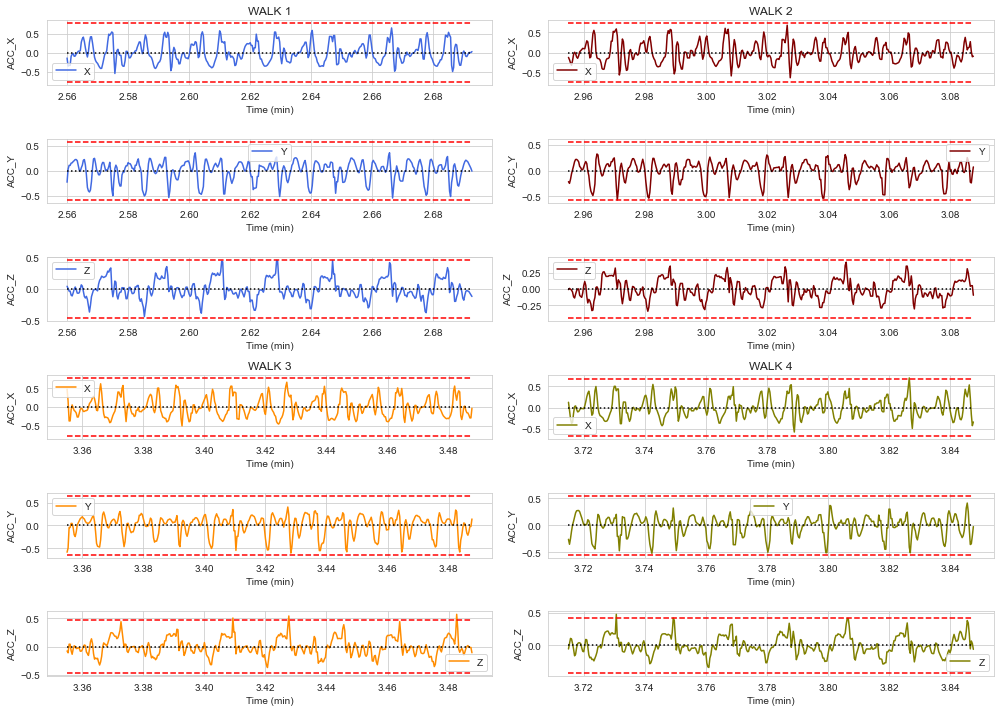

In [37]:
unow = user1_1
walks_user1_1 = [ ufrag(unow, 2.56, 2.693), ufrag(unow, 2.955, 3.088), ufrag(user1_1, 3.355, 3.488), ufrag(user1_1, 3.715, 3.848) ]
walks_user1_1_detrended = []
for i in walks_user1_1:
    walks_user1_1_detrended.append( detrend_user_walk(i) )
plot_user_walks(walks_user1_1_detrended)

### Pela análise visual dos gráficos acima, a ação aparenta ter uma periodicidade próxima dos 0.019 s

In [ ]:
step = 57
plt.figure(figsize = (16,8))
plt.subplot(221)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[0]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[0]['Z'][(i-1)*step: i * step])
    
plt.subplot(222)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[1]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[1]['Z'][(i-1)*step: i * step])
    
plt.subplot(223)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[2]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[2]['Z'][(i-1)*step: i * step])
    
plt.subplot(224)
for i in range(1,399//step + 1):
    plt.plot(walks_user1_1_detrended[3]['Time (min)'][(i-1)*step: i * step], walks_user1_1_detrended[3]['Z'][(i-1)*step: i * step])

In [ ]:
step = 57
plt.figure(figsize = (16,8))

plt.subplot(221)
for i in range(399//step):
    values = np.array(walks_user1_1_detrended[0]['Z'])[i*step:(i+1)*step]
    plt.plot(range(len(values)), values )

plt.subplot(222)
for i in range(399//step):
    values = np.array(walks_user1_1_detrended[1]['Z'])[i*step:(i+1)*step]
    plt.plot(range(len(values)), values )

plt.subplot(223)    
for i in range(399//step):
    values = np.array(walks_user1_1_detrended[1]['Z'])[i*step:(i+1)*step]
    plt.plot(range(len(values)), values )

plt.subplot(224)
for i in range(399//step):
    values = np.array(walks_user1_1_detrended[1]['Z'])[i*step:(i+1)*step]
    plt.plot(range(len(values)), values )

### Como é visível pelos gráficos acima, parece legítimo considerar 57 como um valor aproximado de N para o intervalo criado, havendo uma sobreposição de todas as divisões e aproximando se bastante de um período no gráfico acima. Visualmente, no gráfico anterior, também se verifica que as diferentes cores se assemelham a um período

In [ ]:
N = 399
fs = 50
if N%2==0:
    f = np.arange( -fs/2, fs/2 - fs/2/N + fs/N, fs/N) 
else:
    f = np.arange( -fs/2 + fs/2/N, fs/2 - fs/2/N + fs/N, fs/N)

In [ ]:
dft = np.abs(fftshift(fft(walks_user1_1_detrended[0]['Z'])))
dft[dft<0.2*np.max(dft)]=0

In [ ]:
plot_period_walk_freqs(walks_user1_1_detrended[0], f)

In [ ]:
plot_period_walk_freqs(walks_user1_1_detrended[1], f)

In [ ]:
plot_period_walk_freqs(walks_user1_1_detrended[2], f)

In [ ]:
plot_period_walk_freqs(walks_user1_1_detrended[3], f)

In [ ]:
unow = user2_1
walks_user2_1 = [ ufrag(unow, 2.550, 2.7), ufrag(unow, 2.95, 3.1), ufrag(unow, 3.35, 3.5) ]
walks_user2_1_detrended = []
for i in walks_user2_1:
    walks_user2_1_detrended.append( detrend_user_walk(i) )
plot_user_walks(walks_user2_1_detrended)

In [ ]:




plot_period_walk_freqs(walks_user2_1_detrended[0], f)